# Understanding the relationship between countries MEV 

- Here we will be performing timeseries clustering
    - each run will be for separate MEV:
        - GDP
        - CPI
        - Unempoyment Rate
- Running multi linear regression for all countries

In [1]:
!pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 24.8 MB/s 


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns
import scipy.stats as st

from tslearn.clustering import TimeSeriesKMeans
from tslearn import metrics
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance,  TimeSeriesResampler



from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.linear_model import LinearRegression

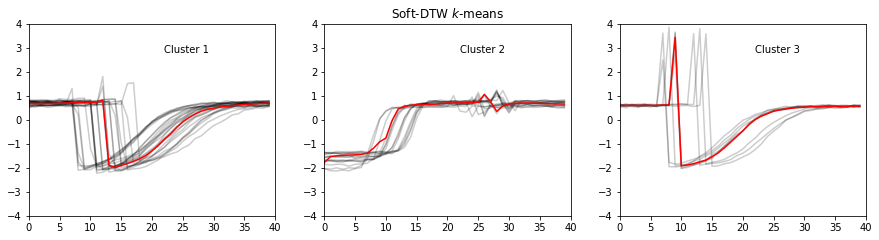

In [ ]:
for yi in range(3):
    plt.subplot(3, 3, 7 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")
    plt.gcf().set_size_inches(15, 12)

**Uploading data and cleaning it**

In [3]:
mev = pd.read_excel('allCountries_IMF.xlsx')

In [4]:
mev.columns.values

array(['WEO Country Code', 'ISO', 'WEO Subject Code', 'Country',
       'Subject Descriptor', 'Subject Notes', 'Units', 'Scale',
       'Country/Series-specific Notes', 1980, 1981, 1982, 1983, 1984,
       1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2020, 2021], dtype=object)

In [5]:
mev = mev.drop(columns=['WEO Country Code', 'ISO', 'WEO Subject Code', 'Subject Notes', 'Scale',
       'Country/Series-specific Notes',])

In [6]:
mev.head(2)

,Country,Subject Descriptor,Units,1980,1981,1982,1983,1984,1985,1986,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Afghanistan,"Gross domestic product, constant prices",National currency,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1092.12,1154.18,1185.31,1197.01,1222.92,1255.29,1270.22,1319.9,1253.91,1304.06
1,Afghanistan,"Gross domestic product, constant prices",Percent change,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.968,5.683,2.697,0.988,2.164,2.647,1.189,3.912,-5,4


In [7]:
df = pd.melt(mev, id_vars=['Country', 'Subject Descriptor', 'Units'], var_name='year', value_name='mev_value')

In [8]:
df.head(2)

,Country,Subject Descriptor,Units,year,mev_value
0,Afghanistan,"Gross domestic product, constant prices",National currency,1980,NaN
1,Afghanistan,"Gross domestic product, constant prices",Percent change,1980,NaN


In [9]:
df_comp = df.dropna(subset=['mev_value'])

In [10]:
df_comp.isnull().sum()

Country               0
Subject Descriptor    0
Units                 0
year                  0
mev_value             0
dtype: int64

In [11]:
def change_names(df):
  if df['Subject Descriptor'] == 'Gross domestic product, current prices' and df['Units'] == 'U.S. dollars':
    return 'GDP'
  elif df['Subject Descriptor'] == 'Inflation, end of period consumer prices' and df['Units'] == 'Index':
    return 'Inflation, CPI'
  elif df['Subject Descriptor'] == 'Unemployment rate':
    return 'Unemployment rate'
  else:
    return 'Other'



df_comp['mev_name'] = df_comp.apply(change_names, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [12]:
df_smaller = df_comp[df_comp['mev_name'] != 'Other']
df_smaller.head(2)

,Country,Subject Descriptor,Units,year,mev_value,mev_name
48,Albania,"Gross domestic product, current prices",U.S. dollars,1980,1.946,GDP
70,Albania,Unemployment rate,Percent of total labor force,1980,5.028,Unemployment rate


In [13]:
df_selected_mev = df_smaller[['Country','year','mev_value','mev_name']]
df_selected_mev.head(2)

,Country,year,mev_value,mev_name
48,Albania,1980,1.946,GDP
70,Albania,1980,5.028,Unemployment rate


In [14]:
gdp_df = df_selected_mev[df_selected_mev['mev_name']=='GDP']
unemp_df = df_selected_mev[df_selected_mev['mev_name']=='Unemployment rate']
cpi_df = df_selected_mev[df_selected_mev['mev_name']=='Inflation, CPI']

------------------------------------------------
### Cluster GDP Dataset
------------------------------------------------

In [15]:
gdp_df_pivot = pd.pivot_table(data=gdp_df, index='Country', columns='year', fill_value=0)
gdp_df_pivot.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/apply.py:507: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  return self._try_aggregate_string_function(obj, f, *self.args, **self.kwargs)


mev_value                                                  \
year                     1980    1981    1982    1983    1984    1985    1986   
Country                                                                         
Afghanistan             0.000   0.000   0.000   0.000   0.000   0.000   0.000   
Albania                 1.946   2.229   2.296   2.319   2.290   2.339   2.587   
Algeria                42.346  44.372  44.780  47.529  51.513  61.132  61.535   
Angola                  6.639   6.214   6.214   6.476   6.864   8.457   7.918   
Antigua and Barbuda     0.131   0.148   0.164   0.182   0.208   0.241   0.290   

                                             ...                             \
year                   1987    1988    1989  ...     2012     2013     2014   
Country                                      ...                              
Afghanistan           0.000   0.000   0.000  ...   20.293   20.170   20.635   
Albania               2.566   2.530   2.779  ...   12.324   12.784   13.246   
Algeria              63.300  51.664  52.558  ...  209.059  209.755  213.810   
Angola                9.050   9.818  11.421  ...  128.053  136.710  145.712   
Antigua and Barbuda   0.337   0.399   0.439  ...    1.200    1.181    1.250   

                                                                           \
year                    2015     2016     2017     2018     2019     2020   
Country                                                                     
Afghanistan           20.220   17.994   18.910   18.401   18.876   19.132   
Albania               11.389   11.862   13.053   15.147   15.276   15.147   
Algeria              165.979  160.034  170.207  175.367  171.070  144.294   
Angola               116.194  101.124  122.124  105.902   89.603   62.440   
Antigua and Barbuda    1.337    1.437    1.468    1.605    1.662    1.390   

                              
year                    2021  
Country                       
Afghanistan           19.938  
Albania               17.138  
Algeria              151.459  
Angola                66.493  
Antigua and Barbuda    1.376  

[5 rows x 42 columns]

In [16]:
gdp_train = np.array(gdp_df_pivot).reshape(gdp_df_pivot.shape[0],gdp_df_pivot.shape[1],1)

In [17]:
gdp_train.shape

(195, 42, 1)

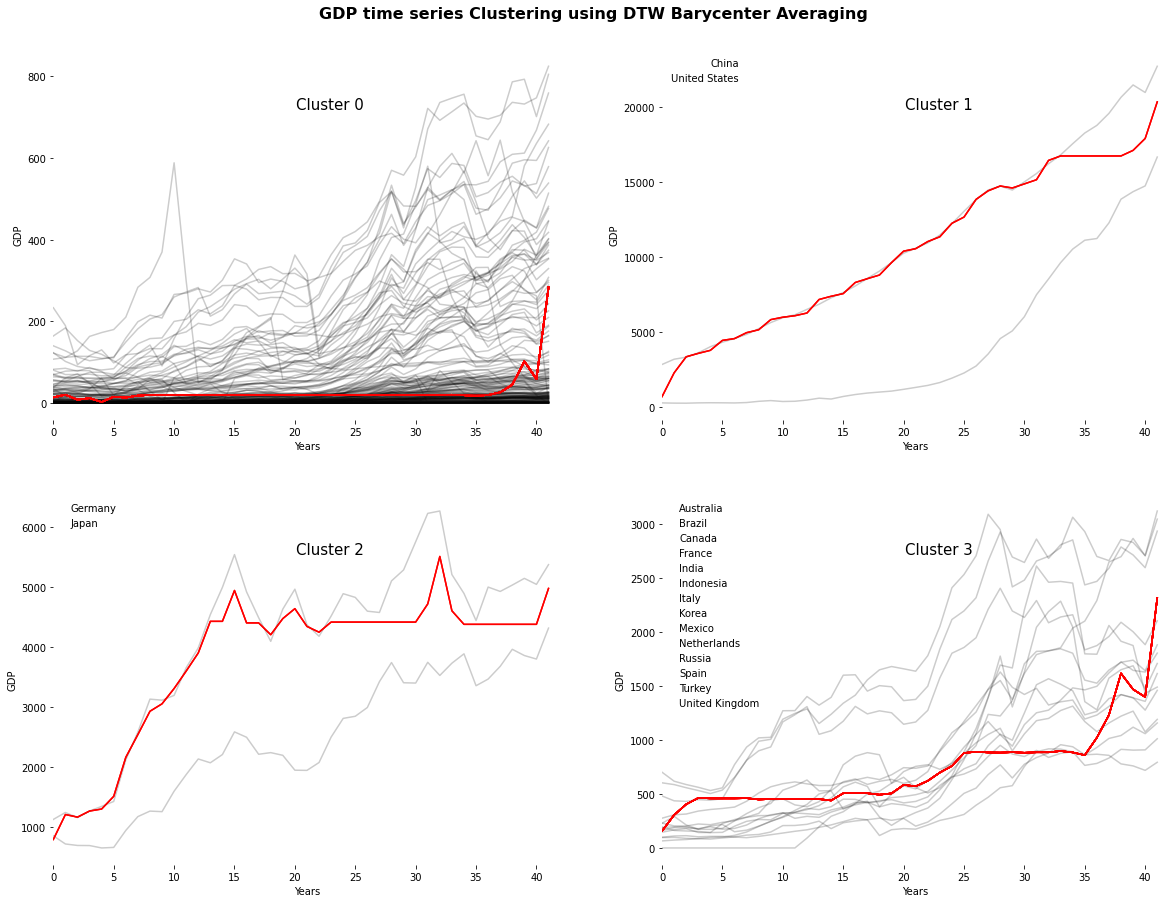

In [54]:
plt.figure(figsize=(20,15))
sz = gdp_train.shape[1]


dba_km = TimeSeriesKMeans(n_clusters=4,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=123)
y_pred_gdp = dba_km.fit_predict(gdp_train)
labels = dict(zip(gdp_df_pivot.index, y_pred_gdp))


for yi in range(4):
    plt.subplot(2, 2, 1 + yi,frameon=False)
    for xx in gdp_train[y_pred_gdp == yi]:
        if yi == 0:
            plt.plot(xx.ravel(), "k-", alpha=.2) 
            #plt.legend([ k for k, v in labels.items() if v == 0 ], loc ='upper left',frameon = False)
            
        elif yi == 1: 
            plt.plot(xx.ravel(), "k-", alpha=.2 )
            plt.legend([ k for k, v in labels.items() if v == 1 ], handlelength=0,loc ='upper left',frameon = False, markerfirst=False)

        elif yi == 2: 
            plt.plot(xx.ravel(), "k-", alpha=.2 )
            plt.legend([ k for k, v in labels.items() if v == 2 ],handlelength=0, loc ='upper left',frameon = False)    
     
        else:
            plt.plot(xx.ravel(), "k-", alpha=.2)
            plt.legend([ k for k, v in labels.items() if v == 3 ], handlelength=0,loc ='upper left',frameon = False)
            
        plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    #plt.ylim(-5, 1000000) color ='green' 
    #plt.legend(df_excep.columns[1:],loc="upper left")
    plt.text(0.55, 0.85,'Cluster %d ' % (yi),horizontalalignment='center',verticalalignment='center',
             transform=plt.gca().transAxes, fontsize=15)
    plt.ylabel('GDP')
    plt.xlabel('Years')
    plt.suptitle('GDP time series Clustering using DTW Barycenter Averaging', fontsize=16, fontweight='bold',y=0.92)
    plt.savefig('GDP_time_series_clusters.png')

In [ ]:
df_gdp_cluster_results = gdp_df_pivot


df_gdp_cluster_results['Cluster'] = y_pred_gdp

In [ ]:
df_gdp_cluster_results[df_gdp_cluster_results['Cluster']==3]

mev_value                                               \
year                1980     1981     1982     1983     1984     1985   
Country                                                                 
Australia        162.628  188.067  186.709  179.151  196.777  174.067   
Brazil           145.819  167.583  179.166  143.652  142.957  226.938   
Canada           276.035  307.246  314.639  341.863  356.728  366.184   
France           702.243  618.954  588.015  562.499  532.339  557.561   
India            189.438  196.535  203.537  222.049  215.556  237.618   
Indonesia         99.296  110.848  113.799  103.149  107.218  107.062   
Italy            482.019  437.124  432.001  448.304  442.925  457.397   
Korea             65.368   72.934   78.349   87.761   97.511  101.296   
Mexico           228.606  293.610  213.077  173.714  204.860  217.388   
Netherlands      193.758  162.400  157.338  153.179  142.578  144.655   
Russia             0.000    0.000    0.000    0.000    0.000    0.000   
Spain            230.759  204.588  197.643  172.856  172.381  181.620   
Turkey            96.596   97.865   88.918   84.968   82.642   92.827   
United Kingdom   603.983  587.652  558.720  532.476  504.571  536.938   

                                                      ...                      \
year               1986     1987      1988      1989  ...      2013      2014   
Country                                               ...                       
Australia       181.147  212.712   270.594   307.720  ...  1518.430  1457.390   
Brazil          263.256  286.539   320.105   439.434  ...  2471.720  2456.060   
Canada          379.015  433.140   509.380   567.225  ...  1846.600  1805.750   
France          772.838  935.117  1020.880  1026.180  ...  2811.920  2856.700   
India           252.751  283.750   299.645   301.234  ...  1856.720  2039.130   
Indonesia       101.220   95.214   107.279   122.582  ...   916.646   891.051   
Italy           647.819  813.082   900.829   936.906  ...  2141.950  2162.570   
Korea           116.836  147.949   199.593   246.929  ...  1370.630  1484.490   
Mexico          150.513  165.058   201.926   246.079  ...  1274.440  1315.360   
Netherlands     201.599  246.928   264.223   260.532  ...   877.186   892.398   
Russia            0.000    0.000     0.000     0.000  ...  2288.430  2048.840   
Spain           251.304  318.389   374.068   412.590  ...  1355.160  1371.580   
Turkey          102.337  118.926   125.032   147.727  ...   957.504   938.512   
United Kingdom  655.086  813.006   989.570  1007.450  ...  2785.060  3067.120   

                                                                            \
year                2015      2016      2017      2018      2019      2020   
Country                                                                      
Australia       1234.820  1266.270  1385.190  1421.300  1391.540  1359.330   
Brazil          1800.050  1796.620  2063.520  1916.930  1877.110  1434.080   
Canada          1556.510  1528.000  1649.270  1721.820  1741.580  1643.410   
France          2439.440  2472.280  2594.240  2791.160  2717.200  2598.910   
India           2103.590  2294.120  2651.470  2701.110  2870.500  2708.770   
Indonesia        860.741   932.066  1015.490  1042.710  1120.040  1059.640   
Italy           1836.820  1876.550  1961.110  2093.090  2005.140  1884.940   
Korea           1466.040  1499.360  1623.070  1725.370  1646.740  1630.870   
Mexico          1171.870  1078.490  1158.910  1222.350  1268.870  1076.160   
Netherlands      765.650   783.844   833.575   914.458   907.151   909.503   
Russia          1356.700  1280.650  1575.140  1653.010  1689.300  1473.580   
Spain           1195.720  1232.570  1312.080  1422.800  1393.640  1278.210   
Turkey           864.071   869.280   858.932   779.599   760.940   719.537   
United Kingdom  2933.430  2703.240  2664.710  2860.980  2833.300  2710.970   

                        Cluster  
year               2021          


In [ ]:
df_gdp_cluster_results['Cluster'].value_counts()

0    177
3     14
1      2
2      2
Name: Cluster, dtype: int64

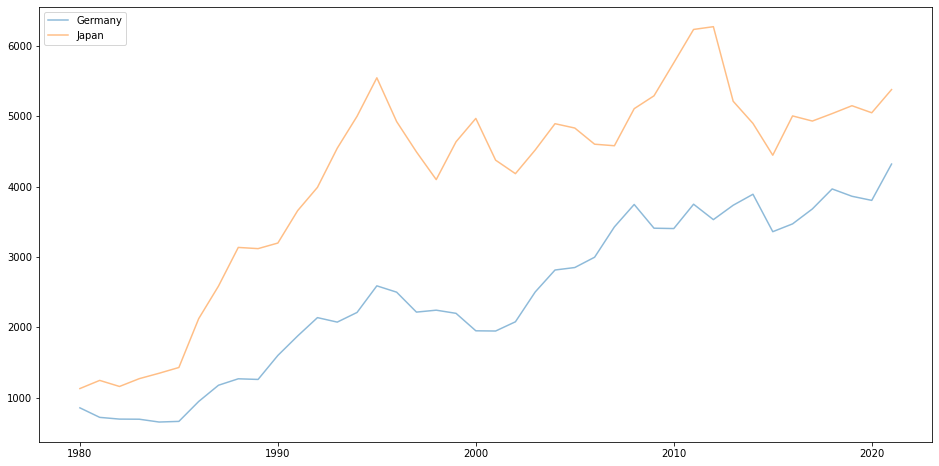

In [ ]:
plot3cl = df_gdp_cluster_results[df_gdp_cluster_results['Cluster']==2].drop(columns='Cluster').T.reset_index(level=0).drop(columns='level_0')
#plot3cl
plt.figure(figsize=(16,8))
plt.plot(plot3cl ,alpha=.5) 
plt.legend([ k for k, v in labels.items() if v == 2 ], loc ='upper left')

In [ ]:
for i in range(4):
    for j in range(4):
        if i < j:
            path, dist = metrics.dtw_path(df_gdp_cluster_results.loc[df_gdp_cluster_results.Cluster==i,df_gdp_cluster_results.columns !='Cluster'], 
                                df_gdp_cluster_results.loc[df_gdp_cluster_results.Cluster==j,df_gdp_cluster_results.columns !='Cluster'])
            print('Distance between cluster ' +str(i)+ ' and '+ str(j)+ ' is  %.2f'%(dist))

Distance between cluster 0 and 1 is  556310.73
Distance between cluster 0 and 2 is  228273.79
Distance between cluster 0 and 3 is  47847.66
Distance between cluster 1 and 2 is  62054.61
Distance between cluster 1 and 3 is  146828.86
Distance between cluster 2 and 3 is  43771.24


In [ ]:
df_gdp_cluster_results.to_excel('gdp_imf_clustered.xlsx')

-------------------------------------------------
### Cluster CPI Dataset
-------------------------------------------------

For CPI we had to eliminate counties with Hyper inflation because their CPI is extremely high that skewed the data a lot

In [ ]:
cpi_df.head()

,Country,year,mev_value,mev_name
108,Algeria,1980,6.573,"Inflation, CPI"
153,Angola,1980,--,"Inflation, CPI"
198,Antigua and Barbuda,1980,42.273,"Inflation, CPI"
423,Austria,1980,54.616,"Inflation, CPI"
513,The Bahamas,1980,36.182,"Inflation, CPI"


In [ ]:
countries_to_drop= ['Venezuela','Ukraine','Brazil','Moldova','South Sudan','Sudan','Uzbekistan']

cpi_df = cpi_df[~cpi_df['Country'].isin(countries_to_drop)]
#cpi_cleaned[cpi_cleaned['Country']=='Ukraine']

In [ ]:
cpi_df['mev_value'].replace('--',0,inplace=True)

In [ ]:
cpi_df2 = cpi_df.drop(columns='mev_name')
cpi_df_pivot = pd.pivot_table(data =cpi_df2 ,values='mev_value',index=cpi_df2['Country'], columns=cpi_df2['year'], fill_value=0)
cpi_df_pivot.head()

year,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,94.687,101.543,103.053,104.218,109.000,112.315,113.162,116.300,122.100,129.182
Albania,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.391,...,95.700,97.400,98.100,100.000,102.165,104.004,105.844,107.143,108.225,110.157
Algeria,6.573,7.009,7.377,8.313,9.199,10.346,11.576,11.942,12.974,14.365,...,158.480,160.300,168.720,176.080,188.330,197.620,202.960,207.900,214.293,225.604
Angola,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,121.447,130.782,140.588,157.587,222.395,275.028,326.194,381.299,477.015,566.215
Antigua and Barbuda,42.273,45.299,46.485,47.932,49.475,49.119,50.085,53.001,55.925,58.654,...,94.107,95.103,96.365,97.233,96.143,98.408,100.120,100.810,103.610,105.693


In [ ]:
cpi_train = np.array(cpi_df_pivot).reshape(cpi_df_pivot.shape[0],cpi_df_pivot.shape[1],1)
cpi_train.shape

(188, 42, 1)

DBA k-means


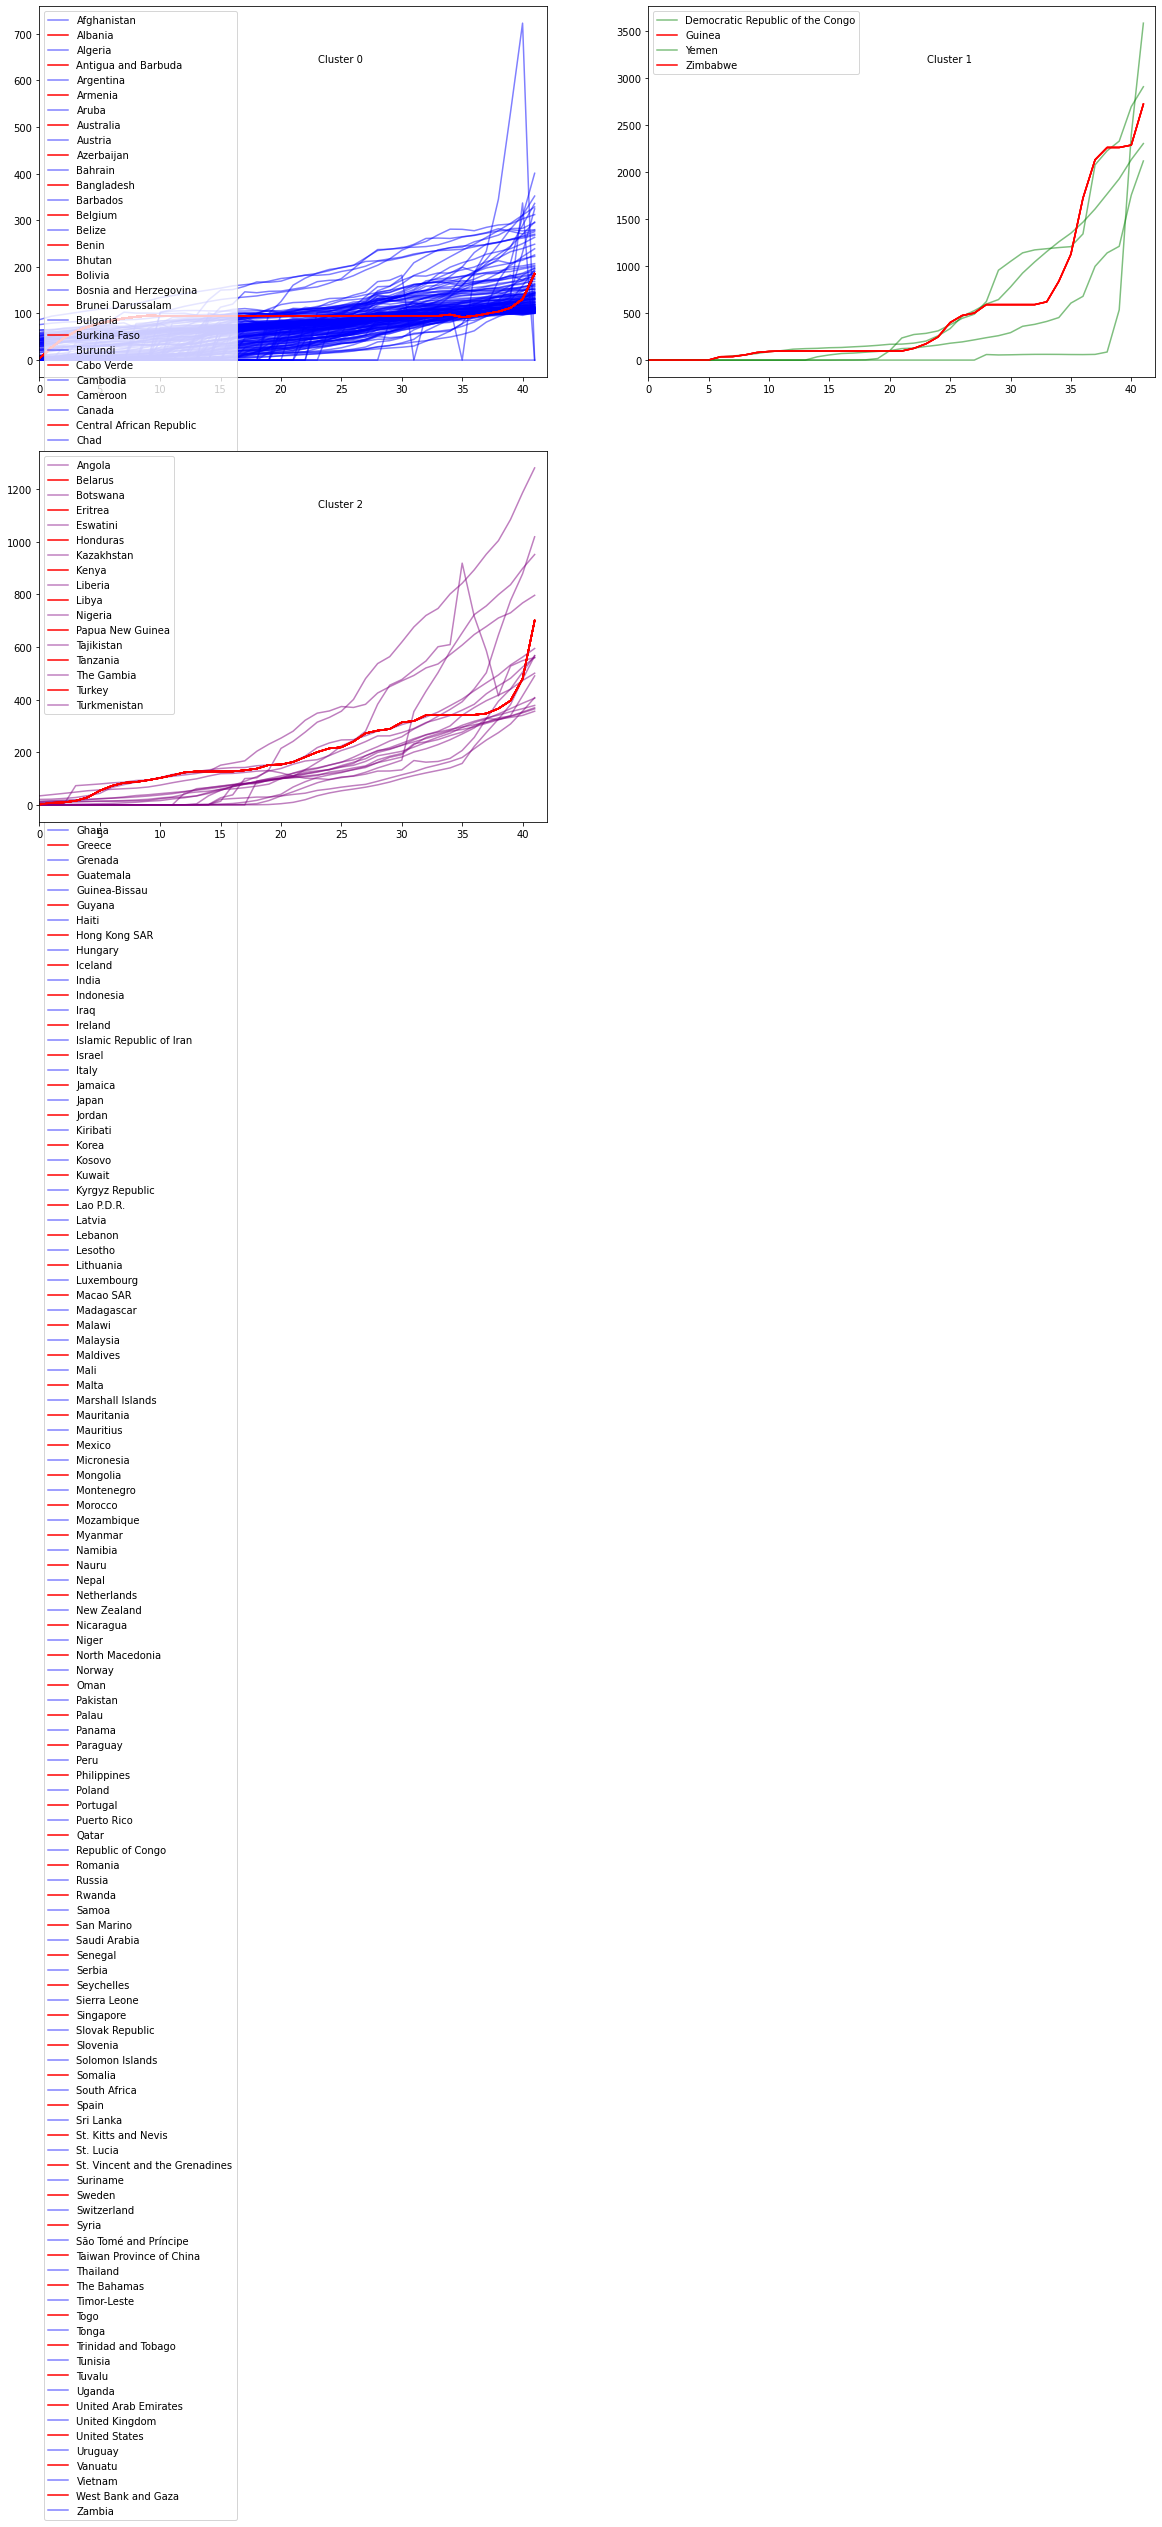

In [ ]:
plt.figure(figsize=(20,15))
sz = cpi_train.shape[1]

# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=123)
y_pred_cpi = dba_km.fit_predict(cpi_train)
labels = dict(zip(cpi_df_pivot.index, y_pred_cpi))


for yi in range(3):
    plt.subplot(2, 2, 1 + yi)
    for xx in cpi_train[y_pred_cpi == yi]:
        if yi == 0:
            plt.plot(xx.ravel(), "k-", alpha=.5, color ='blue' ) 
            plt.legend([ k for k, v in labels.items() if v == 0 ], loc ='upper left')
        elif yi == 1: 
            plt.plot(xx.ravel(), "k-", alpha=.5, color ='green' )
            plt.legend([ k for k, v in labels.items() if v == 1 ], loc ='upper left')

        else:
            plt.plot(xx.ravel(), "k-", alpha=.5, color ='purple' )
            plt.legend([ k for k, v in labels.items() if v == 2 ], loc ='upper left')
            
        plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    #plt.ylim(-5, 1000000)
    #plt.legend(df_excep.columns[1:],loc="upper left")
    plt.text(0.55, 0.85,'Cluster %d ' % (yi),
             transform=plt.gca().transAxes)
    

In [ ]:
df_cpi_cluster_results = cpi_df_pivot


df_cpi_cluster_results['Cluster'] = y_pred_cpi

In [ ]:
df_cpi_cluster_results['Cluster'].value_counts()

0    167
2     17
1      4
Name: Cluster, dtype: int64

In [ ]:
for i in range(3):
    for j in range(3):
        if i < j:
            path, dist = metrics.dtw_path(df_cpi_cluster_results.loc[df_cpi_cluster_results.Cluster==i,df_cpi_cluster_results.columns !='Cluster'], 
                                df_cpi_cluster_results.loc[df_cpi_cluster_results.Cluster==j,df_cpi_cluster_results.columns !='Cluster'])
            print('Distance between cluster ' +str(i)+ ' and '+ str(j)+ ' is  %.2f'%(dist))

Distance between cluster 0 and 1 is  42506.92
Distance between cluster 0 and 2 is  7803.69
Distance between cluster 1 and 2 is  11689.44


In [ ]:
df_cpi_cluster_results.to_excel('cpi_imf_clusterd.xlsx')

--------------------------------------------------------
### Clustering Unemployment Rate
--------------------------------------------------------

In [ ]:
unemp_df.head()

,Country,year,mev_value,mev_name
70,Albania,1980,5.028,Unemployment rate
115,Algeria,1980,15.789,Unemployment rate
250,Argentina,1980,3,Unemployment rate
385,Australia,1980,6.133,Unemployment rate
430,Austria,1980,1.6,Unemployment rate


In [ ]:
unemp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3884 entries, 70 to 368477
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Country    3884 non-null   object
 1   year       3884 non-null   object
 2   mev_value  3884 non-null   object
 3   mev_name   3884 non-null   object
dtypes: object(4)
memory usage: 151.7+ KB


In [ ]:
unemp_df_pivot = pd.pivot_table(data =unemp_df ,values='mev_value',index=unemp_df['Country'], columns=unemp_df['year'], fill_value=0)
unemp_df_pivot.head()

year,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Country,,,,,,,,,,,,,,,,,,,,,
Albania,5.028,4.224,2.813,3.335,4.410,5.853,5.430,5.164,6.033,6.721,...,13.400,15.900,17.500,17.100,15.200,13.700,12.300,11.500,12.500,14.000
Algeria,15.789,15.385,15.000,14.286,16.536,16.901,18.356,20.056,21.801,18.100,...,10.969,9.829,10.600,11.214,10.498,11.709,11.731,11.383,14.242,14.541
Argentina,3.000,5.000,4.500,5.000,5.000,6.250,6.300,6.000,6.500,8.000,...,7.200,7.075,7.250,6.533,8.467,8.350,9.200,9.825,11.364,10.552
Armenia,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,17.300,16.200,17.600,18.500,18.000,20.900,20.500,18.900,24.169,22.766
Aruba,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,9.607,7.599,7.451,7.298,7.694,8.923,7.283,5.100,13.997,19.998


In [ ]:
unemp_train = np.array(unemp_df_pivot).reshape(unemp_df_pivot.shape[0],unemp_df_pivot.shape[1],1)
unemp_train.shape

(114, 42, 1)

DBA k-means


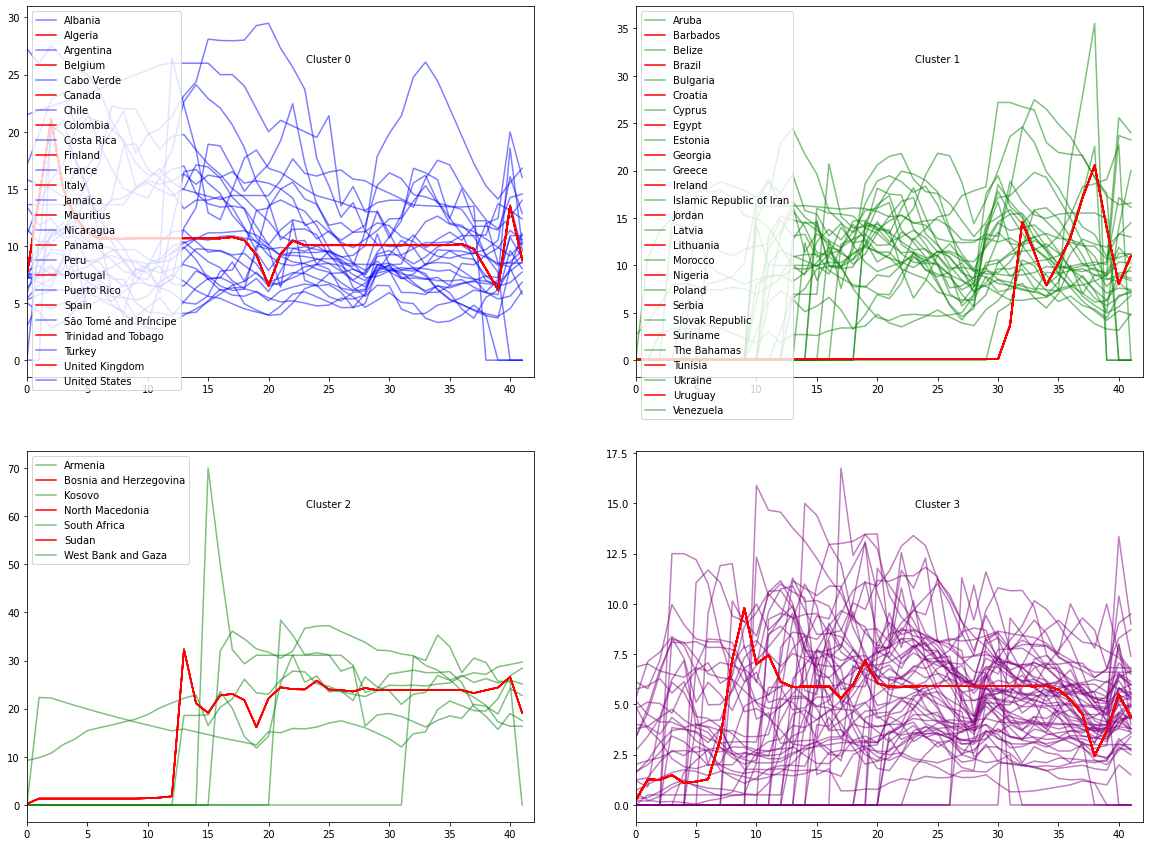

In [ ]:
plt.figure(figsize=(20,15))
sz = unemp_train.shape[1]

# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=4,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=123)
y_pred_unemp = dba_km.fit_predict(unemp_train)
labels = dict(zip(unemp_df_pivot.index, y_pred_unemp))


for yi in range(4):
    plt.subplot(2, 2, 1 + yi)
    for xx in unemp_train[y_pred_unemp == yi]:
        if yi == 0:
            plt.plot(xx.ravel(), "k-", alpha=.5, color ='blue' ) 
            plt.legend([ k for k, v in labels.items() if v == 0 ], loc ='upper left')
        elif yi == 1: 
            plt.plot(xx.ravel(), "k-", alpha=.5, color ='green' )
            plt.legend([ k for k, v in labels.items() if v == 1 ], loc ='upper left')
        
        elif yi == 2: 
          plt.plot(xx.ravel(), "k-", alpha=.5, color ='green' )
          plt.legend([ k for k, v in labels.items() if v == 2 ], loc ='upper left')

        else:
            plt.plot(xx.ravel(), "k-", alpha=.5, color ='purple' )
            #plt.legend([ k for k, v in labels.items() if v == 3 ], loc ='upper left')
            
        plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    #plt.ylim(-5, 1000000)
    #plt.legend(df_excep.columns[1:],loc="upper left")
    plt.text(0.55, 0.85,'Cluster %d ' % (yi),
             transform=plt.gca().transAxes)
    

In [ ]:
df_unemp_cluster_results = unemp_df_pivot


df_unemp_cluster_results['Cluster'] = y_pred_unemp

In [ ]:
df_unemp_cluster_results['Cluster'].value_counts()

3    55
1    27
0    25
2     7
Name: Cluster, dtype: int64

In [ ]:
for i in range(4):
    for j in range(4):
        if i < j:
            path, dist = metrics.dtw_path(df_unemp_cluster_results.loc[df_unemp_cluster_results.Cluster==i,df_unemp_cluster_results.columns !='Cluster'], 
                                df_unemp_cluster_results.loc[df_unemp_cluster_results.Cluster==j,df_unemp_cluster_results.columns !='Cluster'])
            print('Distance between cluster ' +str(i)+ ' and '+ str(j)+ ' is  %.2f'%(dist))

Distance between cluster 0 and 1 is  271.46
Distance between cluster 0 and 2 is  356.44
Distance between cluster 0 and 3 is  292.88
Distance between cluster 1 and 2 is  405.59
Distance between cluster 1 and 3 is  287.17
Distance between cluster 2 and 3 is  641.26


In [ ]:
df_unemp_cluster_results.to_excel('unemploymentRate_imf_clustered.xlsx')

-----------------------------------------------------------
# Running Simple Linear Regression - One country at a time
---------------------------------------------------------

**Knowing that UK belong to cluster 3 in terms of GDP** So we will take only countries within that cluster

In [ ]:
df_gdp_cluster_results.head(2)

mev_value                                                        \
year             1980   1981   1982   1983  1984   1985   1986   1987  1988   
Country                                                                       
Afghanistan     0.000  0.000  0.000  0.000  0.00  0.000  0.000  0.000  0.00   
Albania         1.946  2.229  2.296  2.319  2.29  2.339  2.587  2.566  2.53   

                    ...                                                  \
year          1989  ...    2013    2014    2015    2016    2017    2018   
Country             ...                                                   
Afghanistan  0.000  ...  20.170  20.635  20.220  17.994  18.910  18.401   
Albania      2.779  ...  12.784  13.246  11.389  11.862  13.053  15.147   

                                    Cluster  
year           2019    2020    2021          
Country                                      
Afghanistan  18.876  19.132  19.938       0  
Albania      15.276  15.147  17.138       0  

[2 rows x 43 columns]

In [ ]:
gdp_df_c = df_gdp_cluster_results[df_gdp_cluster_results['Cluster']==3].drop(columns=['Cluster']).reset_index()

gdp_df_c = gdp_df_c.T.reset_index().iloc[:,1:]

gdp_df_c.columns = gdp_df_c.iloc[0]
gdp_df_c = gdp_df_c.iloc[1:,:]
gdp_df_c.columns = ['year', 'Australia', 'Brazil', 'Canada', 'France', 'India',
       'Indonesia', 'Italy', 'Korea', 'Mexico', 'Netherlands', 'Russia',
       'Spain', 'Turkey', 'United Kingdom']

gdp_df_c = gdp_df_c.set_index('year')   
gdp_df_c

,Australia,Brazil,Canada,France,India,Indonesia,Italy,Korea,Mexico,Netherlands,Russia,Spain,Turkey,United Kingdom
year,,,,,,,,,,,,,,
1980,162.628,145.819,276.035,702.243,189.438,99.296,482.019,65.368,228.606,193.758,0.0,230.759,96.596,603.983
1981,188.067,167.583,307.246,618.954,196.535,110.848,437.124,72.934,293.61,162.4,0.0,204.588,97.865,587.652
1982,186.709,179.166,314.639,588.015,203.537,113.799,432.001,78.349,213.077,157.338,0.0,197.643,88.918,558.72
1983,179.151,143.652,341.863,562.499,222.049,103.149,448.304,87.761,173.714,153.179,0.0,172.856,84.968,532.476
1984,196.777,142.957,356.728,532.339,215.556,107.218,442.925,97.511,204.86,142.578,0.0,172.381,82.642,504.571
1985,174.067,226.938,366.184,557.561,237.618,107.062,457.397,101.296,217.388,144.655,0.0,181.62,92.827,536.938
1986,181.147,263.256,379.015,772.838,252.751,101.22,647.819,116.836,150.513,201.599,0.0,251.304,102.337,655.086
1987,212.712,286.539,433.14,935.117,283.75,95.214,813.082,147.949,165.058,246.928,0.0,318.389,118.926,813.006
1988,270.594,320.105,509.38,1020.88,299.645,107.279,900.829,199.593,201.926,264.223,0.0,374.068,125.032,989.57


In [ ]:
test_size = 5

results = dict()

def run_reg(df_all):

  for i in df_all.columns:
    if i != 'United Kingdom':
        
      df = df_all[[i,'United Kingdom']]
      y = np.array(df[i]).reshape(-1, 1)
      X = np.array(df.drop(columns=i)).reshape(-1, 1)
      print(f"Predicting {i} GDP by UK GDP Data:\n\n")
      X_train = X[:-test_size]
      X_test = X[-test_size:]

      y_train = y[:-test_size]
      y_test = y[-test_size:]
      
      # setting pipeline
      pipe = Pipeline(steps = [("standard_scale", StandardScaler()),
                              ("modeling", LinearRegression())])

      pipe.fit(X_train, y_train)

      pred = pipe.predict(X_test)
      MAE = metrics.mean_absolute_error(y_test, pred)
      MSE = metrics.mean_squared_error(y_test, pred)
      RMSE = np.sqrt(metrics.mean_squared_error(y_test, pred))
      R2 = metrics.r2_score(y_test, pred)

      results[i]= R2
      # Metrics
      print('MAE', MAE)
      print('MSE', MSE)
      print('RMSE', RMSE )
      print('R2 Score', R2 )
      print('='*1000)
    



run_reg(gdp_df_c) 

#results

res = pd.DataFrame(results.items(), columns=['Predicted','R2'])

Predicting Australia GDP by UK GDP Data:


MAE 294.9498970808819
MSE 88157.47829697079
RMSE 296.9132504570498
R2 Score -9.108806468589533
Predicting Brazil GDP by UK GDP Data:


MAE 277.5936058344249
MSE 103603.78758540672
RMSE 321.87542246249046
R2 Score -0.6787059274431204
Predicting Canada GDP by UK GDP Data:


MAE 192.02778662516985
MSE 37120.083164441465
RMSE 192.665729086523
R2 Score -3.916099408485314
Predicting France GDP by UK GDP Data:


MAE 66.94011485192887
MSE 5359.947252889918
RMSE 73.21166063469614
R2 Score 0.6766255932525422
Predicting India GDP by UK GDP Data:


MAE 1288.635086371233
MSE 1665213.7250257488
RMSE 1290.431604164184
R2 Score -76.51268258118527
Predicting Indonesia GDP by UK GDP Data:


MAE 420.47525403255577
MSE 177621.45973468546
RMSE 421.45161019349
R2 Score -63.477675909040585
Predicting Italy GDP by UK GDP Data:


MAE 133.86449235681812
MSE 22224.939259556246
RMSE 149.08031144170664
R2 Score -2.246459577753196
Predicting Korea GDP by UK GDP Data:


MAE

In [ ]:
res.sort_values(by='R2', ascending=False)

,Predicted,R2
11,Spain,0.677648
3,France,0.676626
1,Brazil,-0.678706
9,Netherlands,-0.873049
8,Mexico,-1.414294
10,Russia,-1.682713
12,Turkey,-2.173795
6,Italy,-2.246460
2,Canada,-3.916099
0,Australia,-9.108806


In [ ]:
for i in gdp_df_c.columns:
  gdp_df_c[i] = gdp_df_c[i].astype(float)

In [ ]:
gdp_df_c.describe()

,Australia,Brazil,Canada,France,India,Indonesia,Italy,Korea,Mexico,Netherlands,Russia,Spain,Turkey,United Kingdom
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,704.888286,1019.216476,992.614357,1787.681810,1001.887690,428.016143,1435.776095,761.789286,700.622381,548.367929,753.320000,847.388238,429.031762,1841.927667
std,506.165285,776.538587,556.003280,812.548269,910.534703,365.738813,616.525614,555.191558,397.582342,284.610546,768.009882,477.213860,307.390998,889.029070
min,162.628000,142.957000,276.035000,532.339000,189.438000,95.214000,432.001000,65.368000,150.513000,142.578000,0.000000,172.381000,82.642000,504.571000
25%,310.935000,406.732750,579.272500,1272.720000,294.857750,126.501000,1062.222500,295.188250,307.242250,323.828000,0.000000,529.773500,185.081250,1164.012500
50%,423.984500,720.075000,741.799500,1553.655000,485.285000,249.827500,1293.265000,593.323500,718.622000,451.667500,391.373500,637.997000,268.089000,1671.965000
75%,1247.592500,1689.195000,1555.597500,2635.240000,1794.402500,834.369750,1994.132500,1233.182500,1077.907500,845.918500,1453.540000,1322.205000,768.350000,2704.185000
max,1617.540000,2614.030000,1883.490000,2938.270000,3049.700000,1158.780000,2408.390000,1806.710000,1315.360000,1012.600000,2288.430000,1631.690000,957.504000,3124.650000


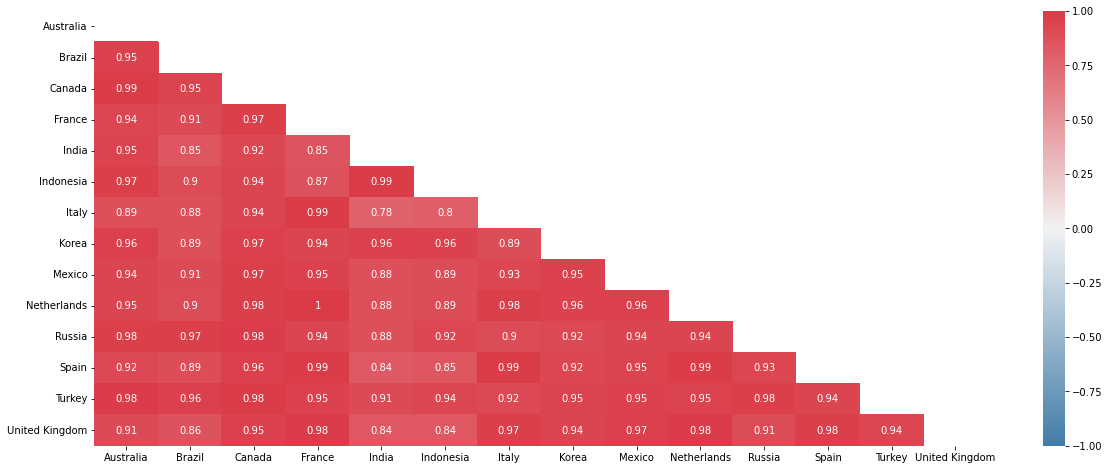

In [ ]:
corr = gdp_df_c.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(240, 10, as_cmap=True)

#corr[abs(corr) <= 0.75] = 0

plt.figure(figsize=(20,8))
sns.heatmap(
    corr,
    mask = mask,
    vmin = -1,
    vmax = 1,
    cmap = cmap,
    annot = True
);

ValueError: ignored

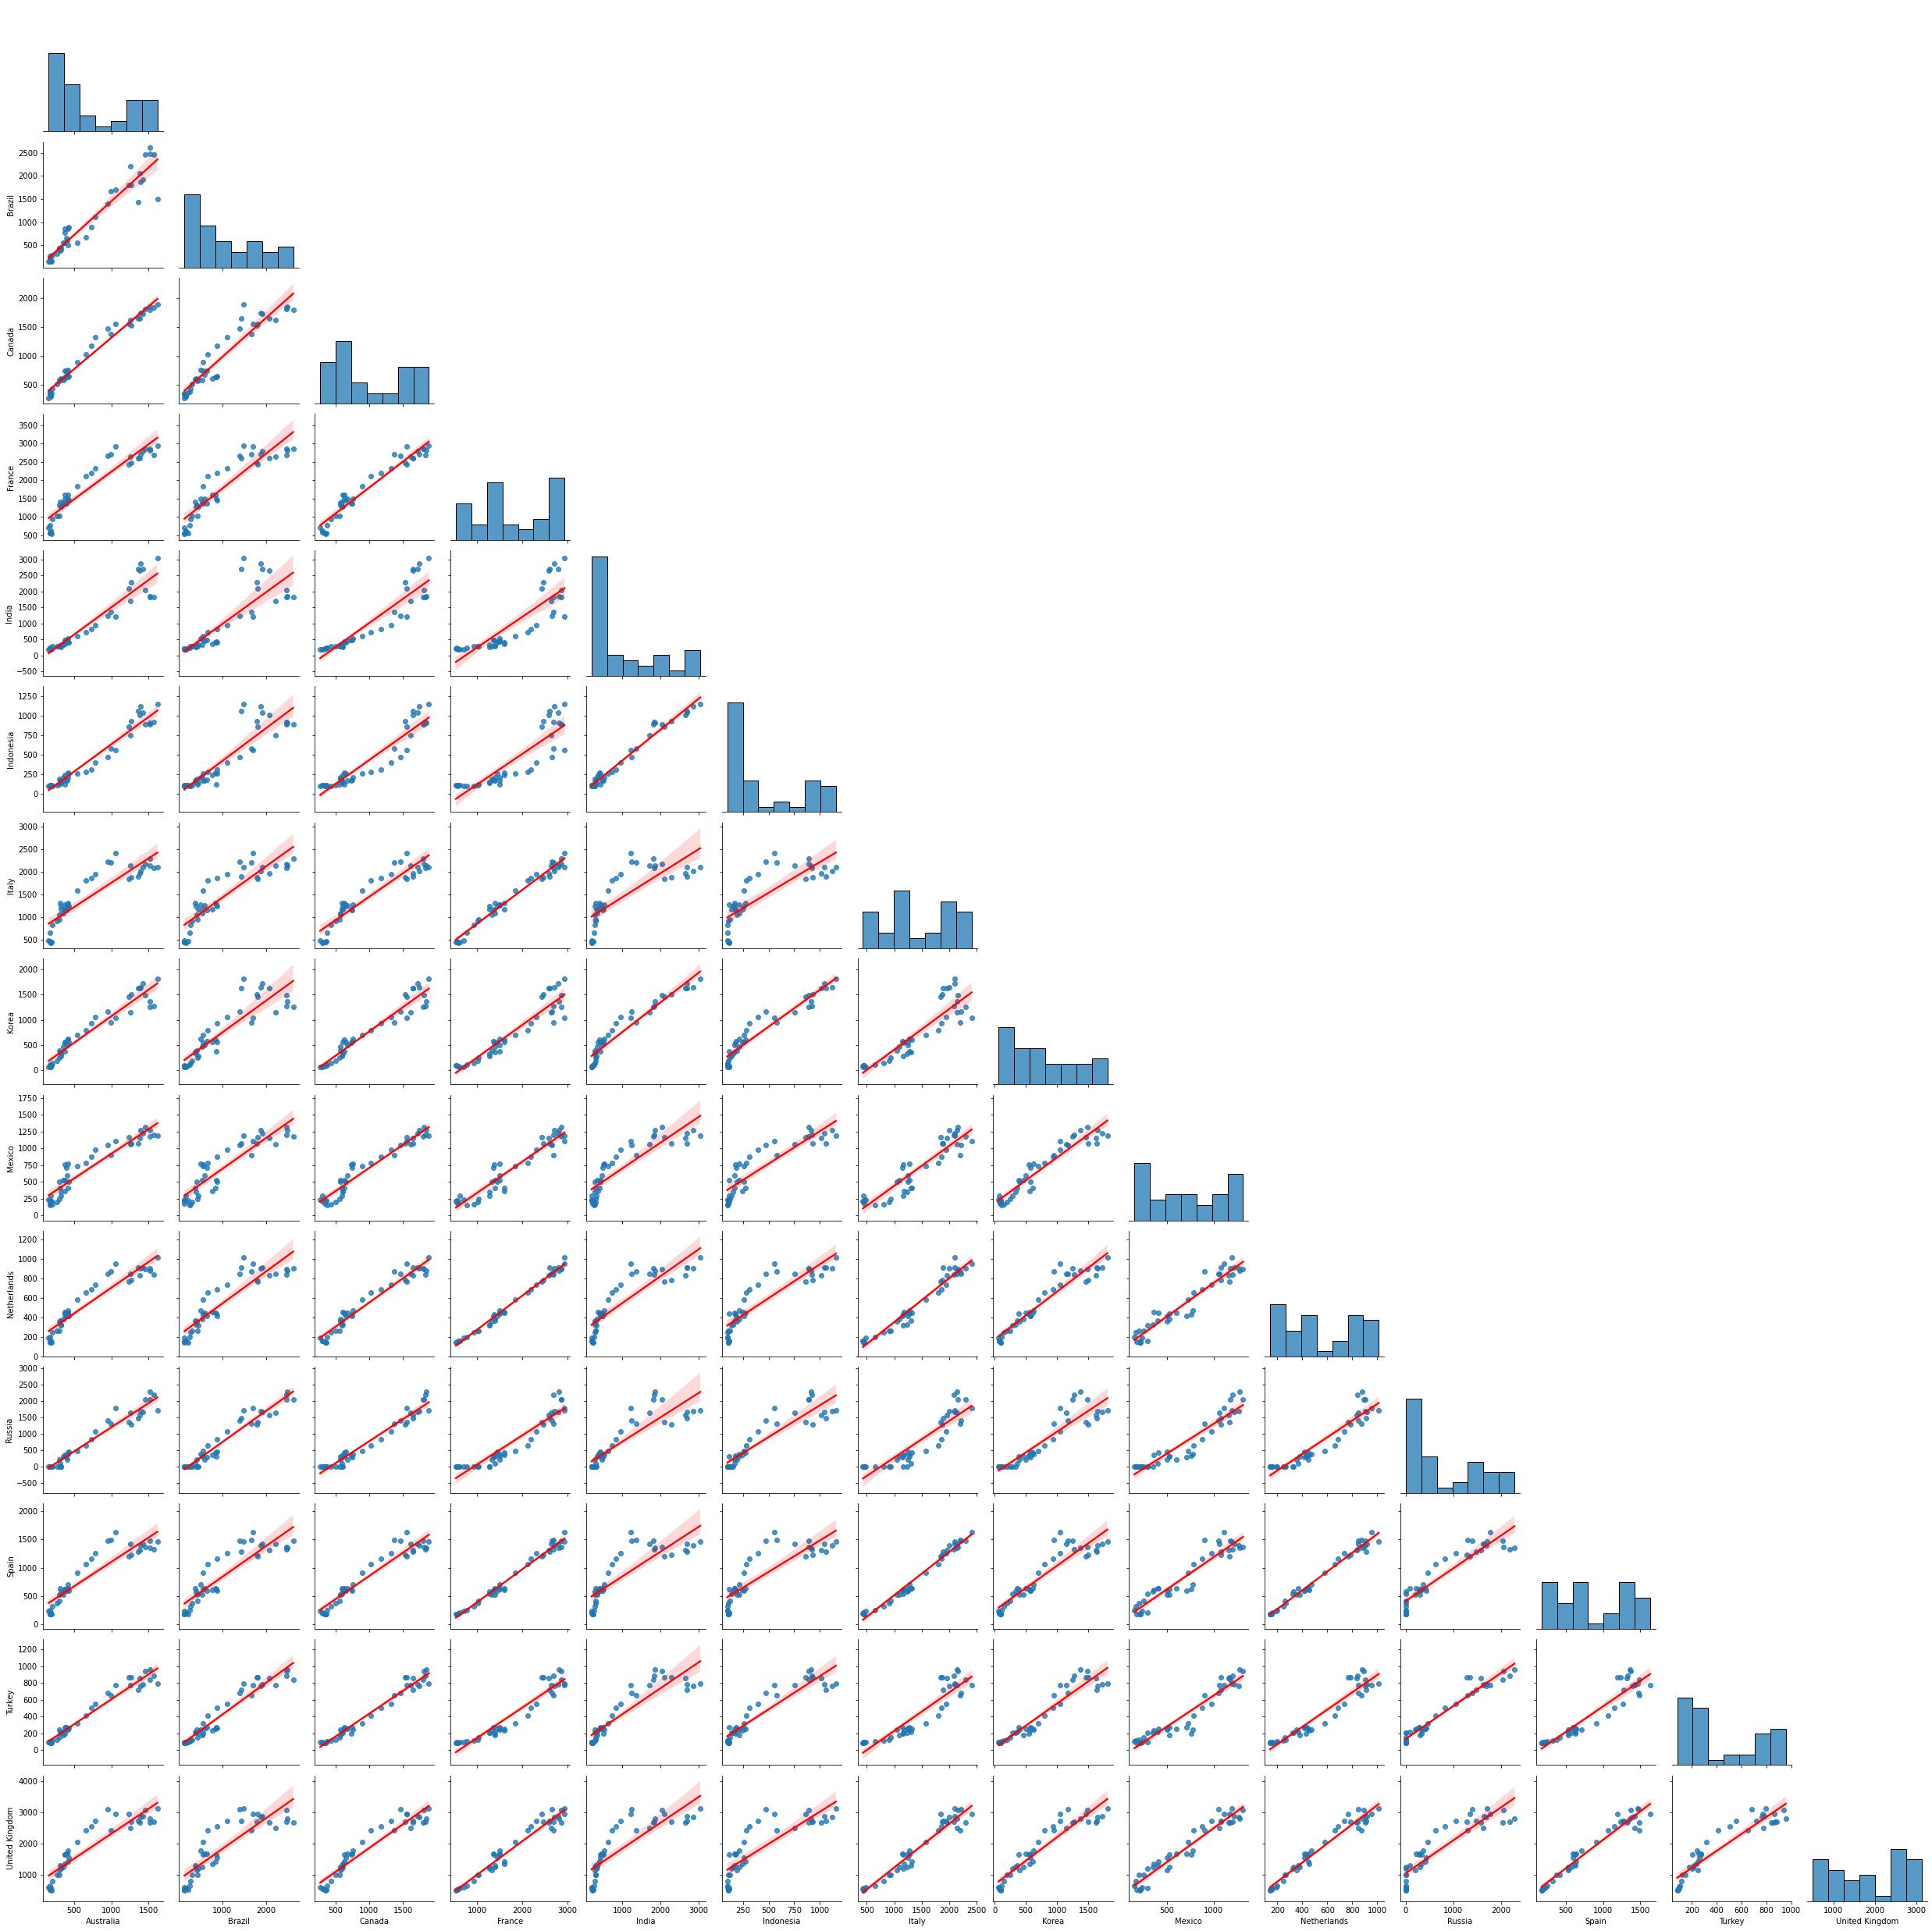

In [ ]:
def corr_annot(x, y, ax=None, **kws):
    """Annotate a plot w/ the correlation coefficient."""
    r,  = st.pearsonr(x, y)
    ax = ax or plt.gca()
    fontsizes = {range(0,21):"medium", range(21,51):'large', range(51,81):'x-large', range(90,101):'xx-large'}

    if r > 0:
        font_size = [fontsize for bound,fontsize in fontsizes.items() if round(abs(r), 1)*100 in bound][0]
        ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes, fontsize = font_size)



g = sns.pairplot(gdp_df_c, 
                 kind = "reg",
                 corner = True,
                 plot_kws = {
                     'line_kws':{'color':'red'},
                     #'logistic':True
                     #'lowess':True
                     });

g.map_lower(corr_annot);

-----------------------------------------------------------
# Running Multiple Linear Regression - One country at a time, by all other countries (same cluster)
---------------------------------------------------------

Predicting Australia by other MEVs:


MAE 64.76683676644666
MSE 5745.760563803071
RMSE 75.80079527157397
R2 Score 0.34114742530770725


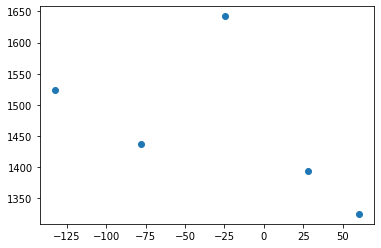

Predicting Brazil by other MEVs:


MAE 618.72217908731
MSE 442480.8715128433
RMSE 665.1923567757249
R2 Score -6.169576316661954


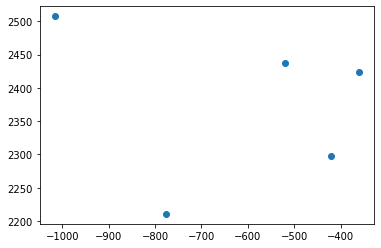

Predicting Canada by other MEVs:


MAE 78.33425842551432
MSE 6601.0864550932165
RMSE 81.24707044006705
R2 Score 0.12576711982341082


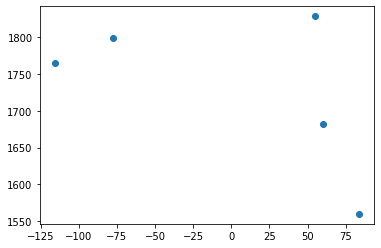

Predicting France by other MEVs:


MAE 73.46467977066996
MSE 6882.454097696694
RMSE 82.96055748183406
R2 Score 0.5847702587727337


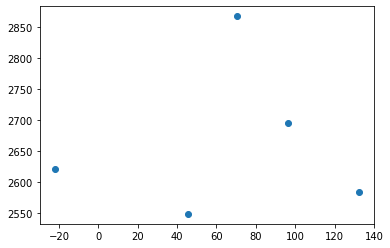

Predicting India by other MEVs:


MAE 337.50733482050293
MSE 123912.75728685086
RMSE 352.0124391081242
R2 Score -4.767914399808713


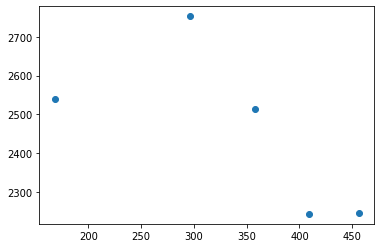

Predicting Indonesia by other MEVs:


MAE 44.87335137263276
MSE 2612.7690515294576
RMSE 51.115252630985374
R2 Score 0.05154885912250917


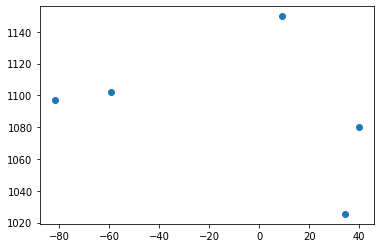

Predicting Italy by other MEVs:


MAE 65.77132130692848
MSE 6406.687264148104
RMSE 80.04178448877876
R2 Score 0.06415711703599414


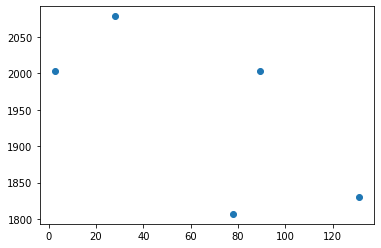

Predicting Korea by other MEVs:


MAE 107.09374607778177
MSE 13089.412412954141
RMSE 114.40896998467446
R2 Score -1.65395214663859


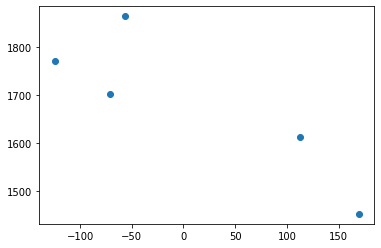

Predicting Mexico by other MEVs:


MAE 165.75829664063676
MSE 31836.082453017065
RMSE 178.42668649340845
R2 Score -6.5784963827682725


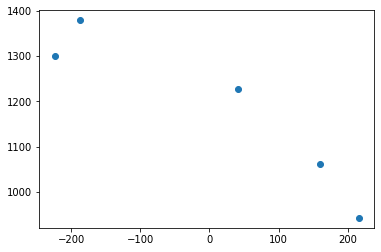

Predicting Netherlands by other MEVs:


MAE 29.98790843584038
MSE 994.1798837050716
RMSE 31.530618194146964
R2 Score 0.6940394163365766


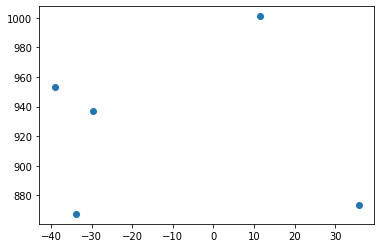

Predicting Russia by other MEVs:


MAE 329.78825387978276
MSE 120158.1511924559
RMSE 346.63835793584053
R2 Score -14.989236488293514


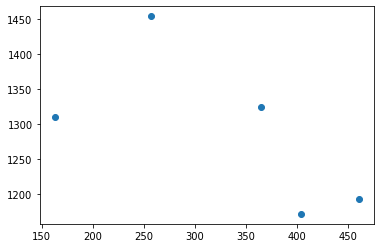

Predicting Spain by other MEVs:


MAE 83.93561068347353
MSE 10417.873317837588
RMSE 102.06798380411747
R2 Score -1.2221107427864162


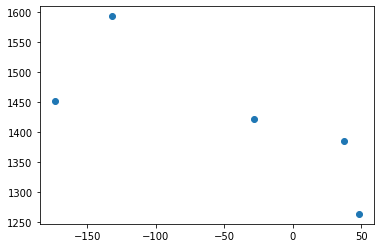

Predicting Turkey by other MEVs:


MAE 163.03481701810068
MSE 30450.625038855662
RMSE 174.5010746065928
R2 Score -13.606094721292722


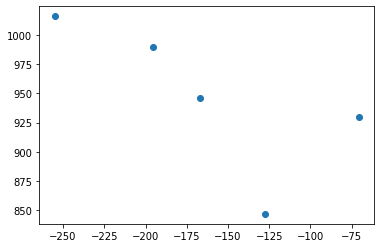

Predicting United Kingdom by other MEVs:


MAE 127.97363201640465
MSE 27890.358189673396
RMSE 167.0040663866404
R2 Score -0.08202659908457544


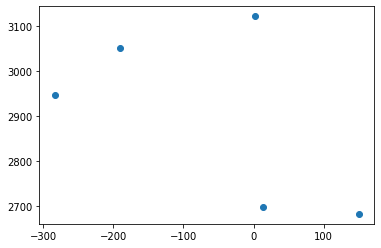

In [ ]:
test_size = 5

results = dict()

def run_reg(df):

  for i in df.columns:
    y = df[i]
    X = df.drop(columns=i)
    print(f"Predicting {i} by other MEVs:\n\n")
    X_train = X[:-test_size]
    X_test = X[-test_size:]

    y_train = y[:-test_size]
    y_test = y[-test_size:]
    
    # setting pipeline
    pipe = Pipeline(steps = [("standard_scale", StandardScaler()),
                             ('imputer', SimpleImputer(strategy='mean')),
                            ("modeling", LinearRegression())])

    pipe.fit(X_train, y_train)

    pred = pipe.predict(X_test)
    MAE = metrics.mean_absolute_error(y_test, pred)
    MSE = metrics.mean_squared_error(y_test, pred)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, pred))
    R2 = metrics.r2_score(y_test, pred)

    results[i]= R2
    # Metrics
    print('MAE', MAE)
    print('MSE', MSE)
    print('RMSE', RMSE )
    print('R2 Score', R2 )
    
    
    residuals = y_test-pred
    plt.scatter(residuals,pred)

    plt.show()
    print('='*1000)
  



run_reg(gdp_df_c) 

#results

res = pd.DataFrame(results.items(), columns=['Predicted','R2'])

In [ ]:
res.sort_values(by='R2', ascending=False)

,Predicted,R2
9,Netherlands,0.694039
3,France,0.584770
0,Australia,0.341147
2,Canada,0.125767
6,Italy,0.064157
5,Indonesia,0.051549
13,United Kingdom,-0.082027
11,Spain,-1.222111
7,Korea,-1.653952
4,India,-4.767914


**Trying to fix heteroskedasticity**

Predicting Australia by other MEVs:


MAE 0.7290752062607146
MSE 0.612242399600971
RMSE 0.7824591999593148
R2 Score -0.20341710668106816


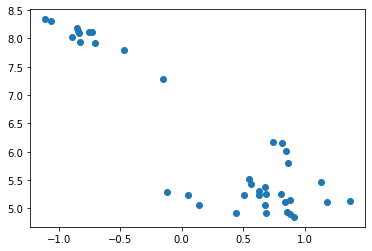

Predicting Brazil by other MEVs:


MAE 3.219940125316194
MSE 12.020203962773023
RMSE 3.4670165795353536
R2 Score -19.202208434607886


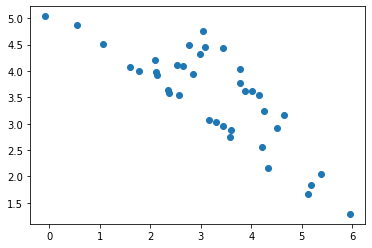

Predicting Canada by other MEVs:


MAE 1.2742331931517925
MSE 2.2190063890947216
RMSE 1.4896329712700112
R2 Score -6.663382746617509


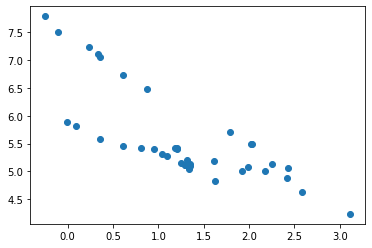

Predicting France by other MEVs:


MAE 1.8739102275953063
MSE 6.2748040139616315
RMSE 2.504955890621955
R2 Score -28.577526721315937


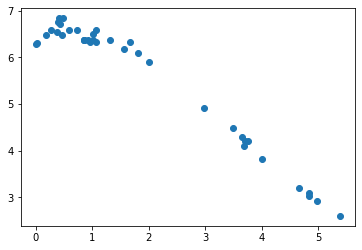

Predicting India by other MEVs:


MAE 2.5672800486311798
MSE 9.711056764358428
RMSE 3.1162568514739646
R2 Score -11.66057819374129


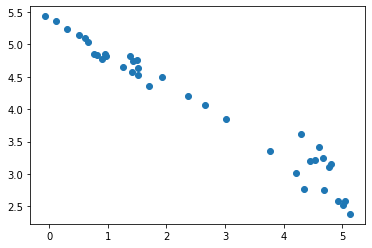

Predicting Indonesia by other MEVs:


MAE 0.761641653392414
MSE 0.9447551366702581
RMSE 0.971985152494758
R2 Score -0.31476128010583504


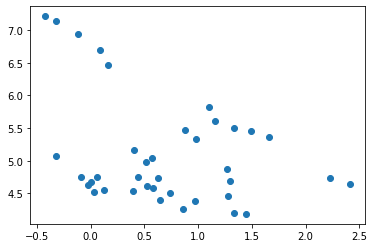

Predicting Italy by other MEVs:


MAE 2.8326007656311596
MSE 11.637088115578313
RMSE 3.4113176509346523
R2 Score -63.012834069749246


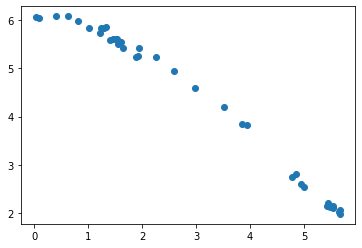

Predicting Korea by other MEVs:


MAE 3.7850153526384083
MSE 17.05928656000953
RMSE 4.130288919677355
R2 Score -23.662714988933935


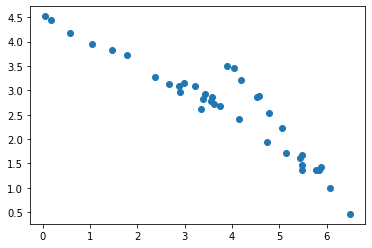

Predicting Mexico by other MEVs:


MAE 7.1901164949762935
MSE 91.67302215403478
RMSE 9.57460297631368
R2 Score -214.1885170774381


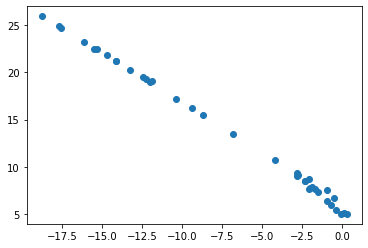

Predicting Netherlands by other MEVs:


MAE 2.8580387699055243
MSE 14.65439728462836
RMSE 3.828106226925836
R2 Score -49.04549785058468


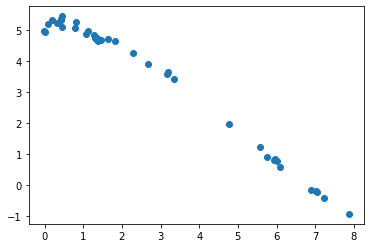

Predicting Russia by other MEVs:




/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: ignored

In [ ]:
test_size = 38

results = dict()

def run_reg(df):

  for i in df.columns:
    y = df[i]
    X = df.drop(columns=i)
    print(f"Predicting {i} by other MEVs:\n\n")
    X_train = X[:-test_size]
    X_test = X[-test_size:]

    y_train = np.log(y[:-test_size])
    y_test = y[-test_size:]
    
    # setting pipeline
    pipe = Pipeline(steps = [('imputer', SimpleImputer(strategy='mean')),
                             ("standard_scale", StandardScaler()),
                             
                            ("modeling", LinearRegression())])

    pipe.fit(X_train, y_train)

    pred = pipe.predict(X_test)
    MAE = metrics.mean_absolute_error(y_test, pred)
    MSE = metrics.mean_squared_error(y_test, pred)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, pred))
    R2 = metrics.r2_score(y_test, pred)

    results[i]= R2
    # Metrics
    print('MAE', MAE)
    print('MSE', MSE)
    print('RMSE', RMSE )
    print('R2 Score', R2 )
    
    
    residuals = y_test-pred
    plt.scatter(residuals,pred)

    plt.show()
    print('='*1000)
  



run_reg(gdp_df_c) 

#results

res = pd.DataFrame(results.items(), columns=['Predicted','R2'])

**Trying GLM**

In [ ]:
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
y = gdp_df_c['Spain']
X = gdp_df_c.drop(columns = 'Spain')

# with GLM (generalized linear model)
leu_model_all = sm.GLM(
    y,
    sm.add_constant(X),
    family=sm.families.Gaussian(sm.families.links.log)
    #sm.families.Binomial(link=sm.genmod.families.links.logit())
    ).fit()

print(leu_model_all.summary())

# We can check the AIC to evaluate the model (lower is better)
print("AIC:", leu_model_all.aic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Spain   No. Observations:                   42
Model:                            GLM   Df Residuals:                       28
Model Family:                Gaussian   Df Model:                           13
Link Function:                    log   Scale:                          2282.5
Method:                          IRLS   Log-Likelihood:                -214.99
Date:                Mon, 18 Jul 2022   Deviance:                       63911.
Time:                        13:57:39   Pearson chi2:                 6.39e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.8471      0.124     39.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  
